# 2D Shock Tube (Planar)

## run 1d and 2d

In [4]:
%load_ext autoreload
%autoreload 2

from __future__ import annotations

from pathlib import Path

import jax
import jax.numpy as jnp
import numpy as np

from compressible_core import chemistry_utils, transport, transport_casseau, chemistry
from compressible_1d import equation_manager as eq1d_manager
from compressible_1d import equation_manager_types as eq1d_types
from compressible_1d import equation_manager_utils as eq1d_utils
from compressible_1d import numerics_types as numerics1d_types

from compressible_2d import equation_manager as eq2d_manager
from compressible_2d import equation_manager_types as eq2d_types
from compressible_2d import equation_manager_utils as eq2d_utils
from compressible_2d import numerics_types as numerics2d_types

import matplotlib.pyplot as plt
import plotly.io as pio

import sys

repo_root = "/home/hhoechter/tum/jaxfluids_internship"

if str(repo_root) not in sys.path:
    sys.path.append(str(repo_root))

from experiments.shock_tube_2d import helpers

pio.templates.default = "plotly_white"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
print("=" * 80)
print("Common Physics Setup")
print("=" * 80)

# --- user input start ---
species_names = ("N2", "N")
use_transport = True
transport_model = "gnoffo"  # gnoffo or casseau
include_diffusion = True
use_chemistry = True
# --- user input end ---

repo_root = Path("/home/hhoechter/tum/jaxfluids_internship")

species_table = helpers.load_species_table(
    species_names,
    general_data_path=str(repo_root / "data/species.json"),
    energy_data_path=str(repo_root / "data/air_5_bird_energy.json"),
)

# Chemistry
reactions = None
if use_chemistry:
    reactions_path = repo_root / "data/park_1990_reactions.json"
    chemistry_config = chemistry.ChemistryModelConfig(
        model="park",
        park_vibrational_source="preferential_constant",
        qp_constant=0.3,
        park_alpha=0.5,
    )
    reactions = chemistry_utils.load_reactions_from_json(
        json_path=str(reactions_path),
        species_table=species_table,
        chemistry_model_config=chemistry_config,
    )

# Transport
collision_integrals = None
casseau_transport = None
transport_config_1d = None
transport_config_2d = None
if use_transport:
    transport_config_1d = eq1d_types.TransportModelConfig(
        model=transport_model,
        include_diffusion=include_diffusion,
    )
    transport_config_2d = eq2d_types.TransportModelConfig(
        model=transport_model,
        include_diffusion=include_diffusion,
    )

    if transport_model == "gnoffo":
        collision_integrals = transport.create_collision_integral_table_from_json(
            repo_root / "data/collision_integrals_tp2867.json"
        )
    elif transport_model == "casseau":
        casseau_transport = transport_casseau.load_casseau_transport_table(
            repo_root / "data/air_5_casseau_transport.json",
            species_names,
        )
        if include_diffusion:
            collision_integrals = transport.create_collision_integral_table_from_json(
                repo_root / "data/collision_integrals_tp2867.json"
            )
    else:
        raise ValueError(f"Unknown transport model: {transport_model}")

Common Physics Setup


2D Domain


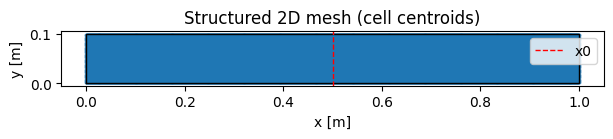

In [6]:
print("=" * 80)
print("2D Domain")
print("=" * 80)

# --- user input start ---
length_x = 1.0
length_y = 0.1
nx = 1000
ny = 20
x0 = 0.5 * length_x

left_tag, right_tag, bottom_tag, top_tag = 1, 2, 3, 4
# --- user input end ---

mesh, dx_2d, dy_2d, x_centers_2d, y_centers_2d = helpers.build_structured_mesh_2d(
    nx, ny, length_x, length_y, boundary_tags=(left_tag, right_tag, bottom_tag, top_tag)
)
cell_shape_2d = (ny, nx)

fig, ax = plt.subplots(figsize=(7, 3))
ax.set_aspect("equal")
ax.plot(
    [0, length_x, length_x, 0, 0],
    [0, 0, length_y, length_y, 0],
    color="black",
    linewidth=1,
)
ax.scatter(mesh.cell_centroids[:, 0], mesh.cell_centroids[:, 1], s=4, alpha=0.6)
ax.axvline(x0, color="red", linestyle="--", linewidth=1, label="x0")
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_title("Structured 2D mesh (cell centroids)")
ax.legend(loc="upper right")
plt.show()

In [7]:
print("=" * 80)
print("Shock Tube Initial Conditions (Shared)")
print("=" * 80)

# --- user input start ---
transition_width = 0.0  # set >0 for smooth tanh transition

# Left state
T_L = 12000.0
p_L = 2.0e6
u_L = 0.0
Tv_L = T_L
Y_L = jnp.array([1.0, 0.0])

# Right state
T_R = 1000.0
p_R = 1.0e5
u_R = 0.0
Tv_R = T_R
Y_R = jnp.array([1.0, 0.0])
# --- user input end ---

Shock Tube Initial Conditions (Shared)


In [8]:
print("=" * 80)
print("Run 2D Simulation")
print("=" * 80)

# --- user input start ---
# time control
use_cfl_2d = False
cfl_2d = 0.4
fixed_dt_2d = 1.0e-8  # used only when use_cfl_2d = False

t_final_2d = 1.6e-5
save_interval_2d = 5
# --- user input end ---

numerics_config_2d = numerics2d_types.NumericsConfig2D(
    dt=fixed_dt_2d,
    cfl=cfl_2d,
    dt_mode="cfl" if use_cfl_2d else "fixed",
    integrator_scheme="rk2",
    spatial_scheme="first_order",
    flux_scheme="hllc",
    axisymmetric=False,
    clipping=numerics2d_types.ClippingConfig2D(),
)

boundary_config_2d = eq2d_types.BoundaryConditionConfig2D(
    tag_to_bc={
        left_tag: {"type": "outflow"},
        right_tag: {"type": "outflow"},
        bottom_tag: {"type": "outflow"},
        top_tag: {"type": "outflow"},
    }
)

eq_manager_2d = eq2d_manager.build_equation_manager(
    mesh,
    species=species_table,
    collision_integrals=collision_integrals,
    reactions=reactions,
    numerics_config=numerics_config_2d,
    boundary_config=boundary_config_2d,
    transport_model=transport_config_2d or eq2d_types.TransportModelConfig(),
    casseau_transport=casseau_transport,
)

# Initial condition (piecewise in x)
rho_L = helpers.compute_density_from_primitives(
    jnp.array([T_L]), jnp.array([p_L]), Y_L[None, :], species_table.molar_masses
)[0]
rho_R = helpers.compute_density_from_primitives(
    jnp.array([T_R]), jnp.array([p_R]), Y_R[None, :], species_table.molar_masses
)[0]

rho_fn = helpers.make_piecewise_fn(x0, rho_L, rho_R, width=transition_width)
u_fn = helpers.make_piecewise_fn(x0, u_L, u_R, width=transition_width)
Y_fn = helpers.make_piecewise_fn(x0, Y_L, Y_R, width=transition_width)
T_fn = helpers.make_piecewise_fn(x0, T_L, T_R, width=transition_width)
Tv_fn = helpers.make_piecewise_fn(x0, Tv_L, Tv_R, width=transition_width)

x_cells = jnp.asarray(mesh.cell_centroids[:, 0])

rho, u, T, Tv, Y = helpers.build_initial_state_1d(
    x_cells, species_table, rho_fn, u_fn, Y_fn, p_fn=None, T_fn=T_fn, Tv_fn=Tv_fn
)
v = jnp.zeros_like(u)

U_init_2d = eq2d_utils.compute_U_from_primitives(
    Y_s=Y,
    rho=rho,
    u=u,
    v=v,
    T_tr=T,
    T_V=Tv,
    equation_manager=eq_manager_2d,
)

U_hist_2d, t_hist_2d = eq2d_manager.run_scan(
    U_init_2d,
    mesh,
    eq_manager_2d,
    t_final=t_final_2d,
    save_interval=save_interval_2d,
)

print(f"2D snapshots: {U_hist_2d.shape[0]}, cells: {U_hist_2d.shape[1]}")

Run 2D Simulation
2D snapshots: 321, cells: 20000


In [9]:
print("=" * 80)
print("Run 1D Simulation")
print("=" * 80)

# --- user input start ---
# grid
n_cells_1d = 1000

# time control
fixed_dt_1d = 1.0e-8
t_final_1d = 1.6e-5
save_interval_1d = 1

boundary_condition_1d = "transmissive"  # transmissive, reflective, periodic
# --- user input end ---

x_1d, dx_1d = helpers.build_grid_1d(n_cells_1d, length_x)

numerics_config_1d = numerics1d_types.NumericsConfig(
    dt=fixed_dt_1d,
    dx=dx_1d,
    integrator_scheme="rk2",
    spatial_scheme="muscl",
    flux_scheme="hllc",
    n_halo_cells=1,
    clipping=numerics1d_types.ClippingConfig(),
)

eq_manager_1d = eq1d_types.EquationManager(
    species=species_table,
    collision_integrals=collision_integrals,
    reactions=reactions,
    numerics_config=numerics_config_1d,
    boundary_condition=boundary_condition_1d,
    transport_model=transport_config_1d or eq1d_types.TransportModelConfig(),
    casseau_transport=casseau_transport,
)

rho_L = helpers.compute_density_from_primitives(
    jnp.array([T_L]), jnp.array([p_L]), Y_L[None, :], species_table.molar_masses
)[0]
rho_R = helpers.compute_density_from_primitives(
    jnp.array([T_R]), jnp.array([p_R]), Y_R[None, :], species_table.molar_masses
)[0]

rho_fn = helpers.make_piecewise_fn(x0, rho_L, rho_R, width=transition_width)
u_fn = helpers.make_piecewise_fn(x0, u_L, u_R, width=transition_width)
Y_fn = helpers.make_piecewise_fn(x0, Y_L, Y_R, width=transition_width)
T_fn = helpers.make_piecewise_fn(x0, T_L, T_R, width=transition_width)
Tv_fn = helpers.make_piecewise_fn(x0, Tv_L, Tv_R, width=transition_width)

rho, u, T, Tv, Y = helpers.build_initial_state_1d(
    x_1d, species_table, rho_fn, u_fn, Y_fn, p_fn=None, T_fn=T_fn, Tv_fn=Tv_fn
)

U_init_1d = eq1d_utils.compute_U_from_primitives(
    Y_s=Y, rho=rho, u=u, T_tr=T, T_V=Tv, equation_manager=eq_manager_1d
)

U_hist_1d, t_hist_1d = eq1d_manager.run_scan(
    U_init=U_init_1d,
    equation_manager=eq_manager_1d,
    t_final=t_final_1d,
    save_interval=save_interval_1d,
)

print(f"1D snapshots: {U_hist_1d.shape[0]}, cells: {U_hist_1d.shape[1]}")

Run 1D Simulation
1D snapshots: 1601, cells: 1000


## plot

In [10]:
print("=" * 80)
print("Centerline Spacetime Heatmaps")
print("=" * 80)

# --- user input start ---
spacetime_downsample_2d = 10  # use every Nth snapshot (1 = all)
spacetime_downsample_1d = 50
# --- user input end ---

# --- 2D centerline ---
U_2d_reshaped = U_hist_2d.reshape(
    (U_hist_2d.shape[0], cell_shape_2d[0], cell_shape_2d[1], -1)
)
j_center = cell_shape_2d[0] // 2
U_2d_center = U_2d_reshaped[:, j_center, :, :]

U_2d_sub = U_2d_center[::spacetime_downsample_2d]
t_2d_sub = t_hist_2d[::spacetime_downsample_2d]

extract_2d = eq2d_utils.extract_primitives_from_U
Y_2d, rho_2d, u_2d, v_2d, T_2d, Tv_2d, p_2d = jax.vmap(extract_2d, in_axes=(0, None))(
    U_2d_sub, eq_manager_2d
)

primitives_2d = {
    "rho [kg/m3]": np.array(rho_2d),
    "u [m/s]": np.array(u_2d),
    "p [Pa]": np.array(p_2d),
    "T (trans-rot) [K]": np.array(T_2d),
    "T (vib-elec) [K]": np.array(Tv_2d),
    "T - Tv [K]": np.array(T_2d - Tv_2d),
}

# --- 1D ---
U_1d_sub = U_hist_1d[::spacetime_downsample_1d]
t_1d_sub = t_hist_1d[::spacetime_downsample_1d]

extract_1d = eq1d_utils.extract_primitives_from_U
Y_1d, rho_1d, T_1d, Tv_1d, p_1d = jax.vmap(extract_1d, in_axes=(0, None))(
    U_1d_sub, eq_manager_1d
)

u_1d = U_1d_sub[:, :, eq_manager_1d.species.n_species] / rho_1d

primitives_1d = {
    "rho [kg/m3]": np.array(rho_1d),
    "u [m/s]": np.array(u_1d),
    "p [Pa]": np.array(p_1d),
    "T (trans-rot) [K]": np.array(T_1d),
    "T (vib-elec) [K]": np.array(Tv_1d),
    "T - Tv [K]": np.array(T_1d - Tv_1d),
}

shared_color_limits = {}
for name in primitives_2d:
    if name not in primitives_1d:
        continue
    vmin = np.nanmin([np.nanmin(primitives_2d[name]), np.nanmin(primitives_1d[name])])
    vmax = np.nanmax([np.nanmax(primitives_2d[name]), np.nanmax(primitives_1d[name])])
    shared_color_limits[name] = (float(vmin), float(vmax))

shared_x_range = (
    float(np.nanmin([np.nanmin(x_centers_2d), np.nanmin(x_1d)])),
    float(np.nanmax([np.nanmax(x_centers_2d), np.nanmax(x_1d)])),
)
shared_t_range = (
    float(np.nanmin([np.nanmin(t_2d_sub), np.nanmin(t_1d_sub)])),
    float(np.nanmax([np.nanmax(t_2d_sub), np.nanmax(t_1d_sub)])),
)

fig = helpers.make_spacetime_heatmap_figure_2rows(
    x_centers_2d,
    t_2d_sub,
    primitives_2d,
    x_1d,
    t_1d_sub,
    primitives_1d,
    title="Centerline Spacetime Heatmaps",
    color_limits=shared_color_limits,
    x_range=shared_x_range,
    y_range=shared_t_range,
    row_titles=(
        f"2D centerline (y = {float(y_centers_2d[j_center]):.3g} m)",
        "1D",
    ),
)
fig.show()

Centerline Spacetime Heatmaps


2D Domain Heatmaps


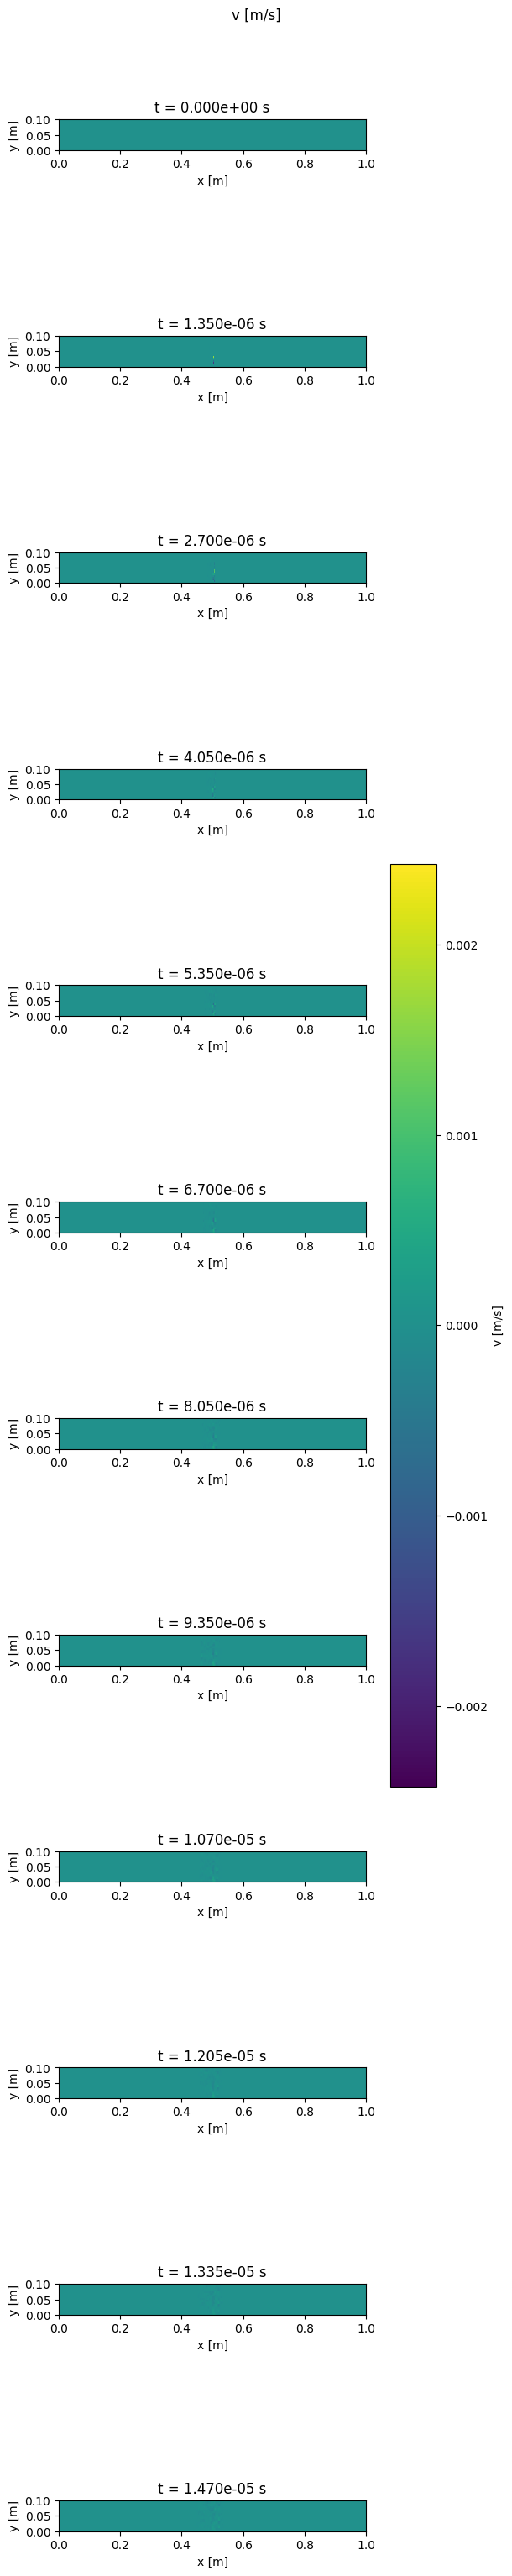

In [13]:
print("=" * 80)
print("2D Domain Heatmaps")
print("=" * 80)

from typing import Literal

# --- user input start ---
max_plots = 12
plot_every_seconds = t_final_2d / max_plots
primitive_to_plot: Literal["u", "v", "speed", "rho", "p", "T", "Tv"] = "v"

# --- user input end ---

if plot_every_seconds <= 0:
    plot_indices = list(range(len(t_hist_2d)))
    plot_times = list(np.array(t_hist_2d))
else:
    t_vals = np.array(t_hist_2d)
    plot_indices = []
    plot_times = []
    next_time = 0.0
    for i, t in enumerate(t_vals):
        if t + 1e-15 >= next_time:
            plot_indices.append(i)
            plot_times.append(t)
            next_time += plot_every_seconds
            if max_plots is not None and len(plot_indices) >= max_plots:
                break

labels = {
    "rho": "rho [kg/m3]",
    "u": "u [m/s]",
    "v": "v [m/s]",
    "speed": "|u| [m/s]",
    "p": "p [Pa]",
    "T": "T (trans-rot) [K]",
    "Tv": "T (vib-elec) [K]",
}


def compute_field(U_snapshot):
    Y, rho, u, v, T, Tv, p = eq2d_utils.extract_primitives_from_U(
        U_snapshot, eq_manager_2d
    )
    speed = jnp.sqrt(u**2 + v**2)
    fields = {
        "rho": rho,
        "u": u,
        "v": v,
        "speed": speed,
        "p": p,
        "T": T,
        "Tv": Tv,
    }
    return fields[primitive_to_plot]


fields = []
for idx in plot_indices:
    U_snapshot = U_hist_2d[idx]
    field = np.array(compute_field(U_snapshot)).reshape(cell_shape_2d)
    fields.append(field)

if not fields:
    raise ValueError("No snapshots selected for plotting.")

vmin = float(np.min(fields))
vmax = float(np.max(fields))

n_plots = len(fields)
ncols = 1
nrows = n_plots

fig, axes = plt.subplots(
    nrows,
    ncols,
    figsize=(6.0, 2.6 * nrows),
    constrained_layout=True,
)

axes = np.array(axes).reshape(-1)

im = None
for ax, field, t in zip(axes, fields, plot_times):
    im = ax.pcolormesh(
        x_centers_2d,
        y_centers_2d,
        field,
        shading="nearest",
        vmin=vmin,
        vmax=vmax,
    )
    ax.set_aspect("equal")
    ax.set_title(f"t = {t:.3e} s")
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")

fig.suptitle(labels[primitive_to_plot])
fig.colorbar(im, ax=axes.tolist(), label=labels[primitive_to_plot])
plt.show()